In [1]:
import torch
print("Is CUDA available? ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())
print("Device name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


Is CUDA available?  True
CUDA device count:  1
Device name:  NVIDIA GeForce RTX 2050


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# Define dataset class for image-mask pairs
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.resize(image, (128, 128))
        image = image / 255.0
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (128, 128))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=0)

        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        return image, mask


In [4]:
# Load image and mask paths
def load_dataset(image_dir, mask_dir):
    image_paths = []
    mask_paths = []
    valid_exts = ('.png', '.jpg', '.jpeg', '.tif')

    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(valid_exts):
                image_paths.append(os.path.join(root, file))

    for root, _, files in os.walk(mask_dir):
        for file in files:
            if file.lower().endswith(valid_exts):
                mask_paths.append(os.path.join(root, file))

    image_paths.sort()
    mask_paths.sort()

    print(f"Found {len(image_paths)} images and {len(mask_paths)} masks")
    return image_paths, mask_paths

# ✅ Unpack both values!
image_paths, mask_paths = load_dataset(
    "D:/Flood-Area-Segmentation-UNet-main/Dataset/Image",
    "D:/Flood-Area-Segmentation-UNet-main/Dataset/Mask"
)

# ✅ No error now
X_train, X_val, y_train, y_val = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)


train_dataset = SegmentationDataset(X_train, y_train)
val_dataset = SegmentationDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


Found 290 images and 290 masks


In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = CBR(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = CBR(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.conv_last = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((dec1, enc1), dim=1))

        return torch.sigmoid(self.conv_last(dec1))


In [8]:
import matplotlib.pyplot as plt

def predict_and_visualize(model, dataset, num_samples=5):
    model.eval()
    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(image)
        pred = pred.squeeze().cpu().numpy()
        image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)
        mask_np = mask.squeeze().cpu().numpy()

        # Plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image_np)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask_np, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred > 0.5, cmap='gray')  # Binarize output
        plt.axis('off')

        plt.tight_layout()
        plt.show()


In [ ]:
predict_and_visualize(model, val_dataset)

Using device: cuda
Total Images: 290, Total Masks: 290


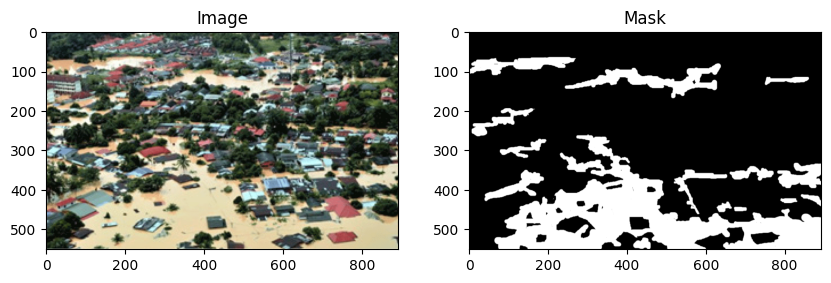

✅ Model will be saved to: d:\Flood-Area-Segmentation-UNet-main\best_unet_model.pth
  Batch 0/29, Loss: 0.3238
  Batch 10/29, Loss: 0.1359
  Batch 20/29, Loss: 0.1222
Epoch 1, Loss: 0.1548, Val Dice: 0.7584, Val IoU: 0.6160
💾 Best model saved to: d:\Flood-Area-Segmentation-UNet-main\best_unet_model.pth
  Batch 0/29, Loss: 0.0853
  Batch 10/29, Loss: 0.0703
  Batch 20/29, Loss: 0.0783
Epoch 2, Loss: 0.0826, Val Dice: 0.7958, Val IoU: 0.6667
💾 Best model saved to: d:\Flood-Area-Segmentation-UNet-main\best_unet_model.pth
  Batch 0/29, Loss: 0.0722
  Batch 10/29, Loss: 0.0474
  Batch 20/29, Loss: 0.0984
Epoch 3, Loss: 0.0729, Val Dice: 0.8077, Val IoU: 0.6832
💾 Best model saved to: d:\Flood-Area-Segmentation-UNet-main\best_unet_model.pth
  Batch 0/29, Loss: 0.0642
  Batch 10/29, Loss: 0.0652
  Batch 20/29, Loss: 0.0548
Epoch 4, Loss: 0.0651, Val Dice: 0.8531, Val IoU: 0.7487
💾 Best model saved to: d:\Flood-Area-Segmentation-UNet-main\best_unet_model.pth
  Batch 0/29, Loss: 0.0487
  Batch 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


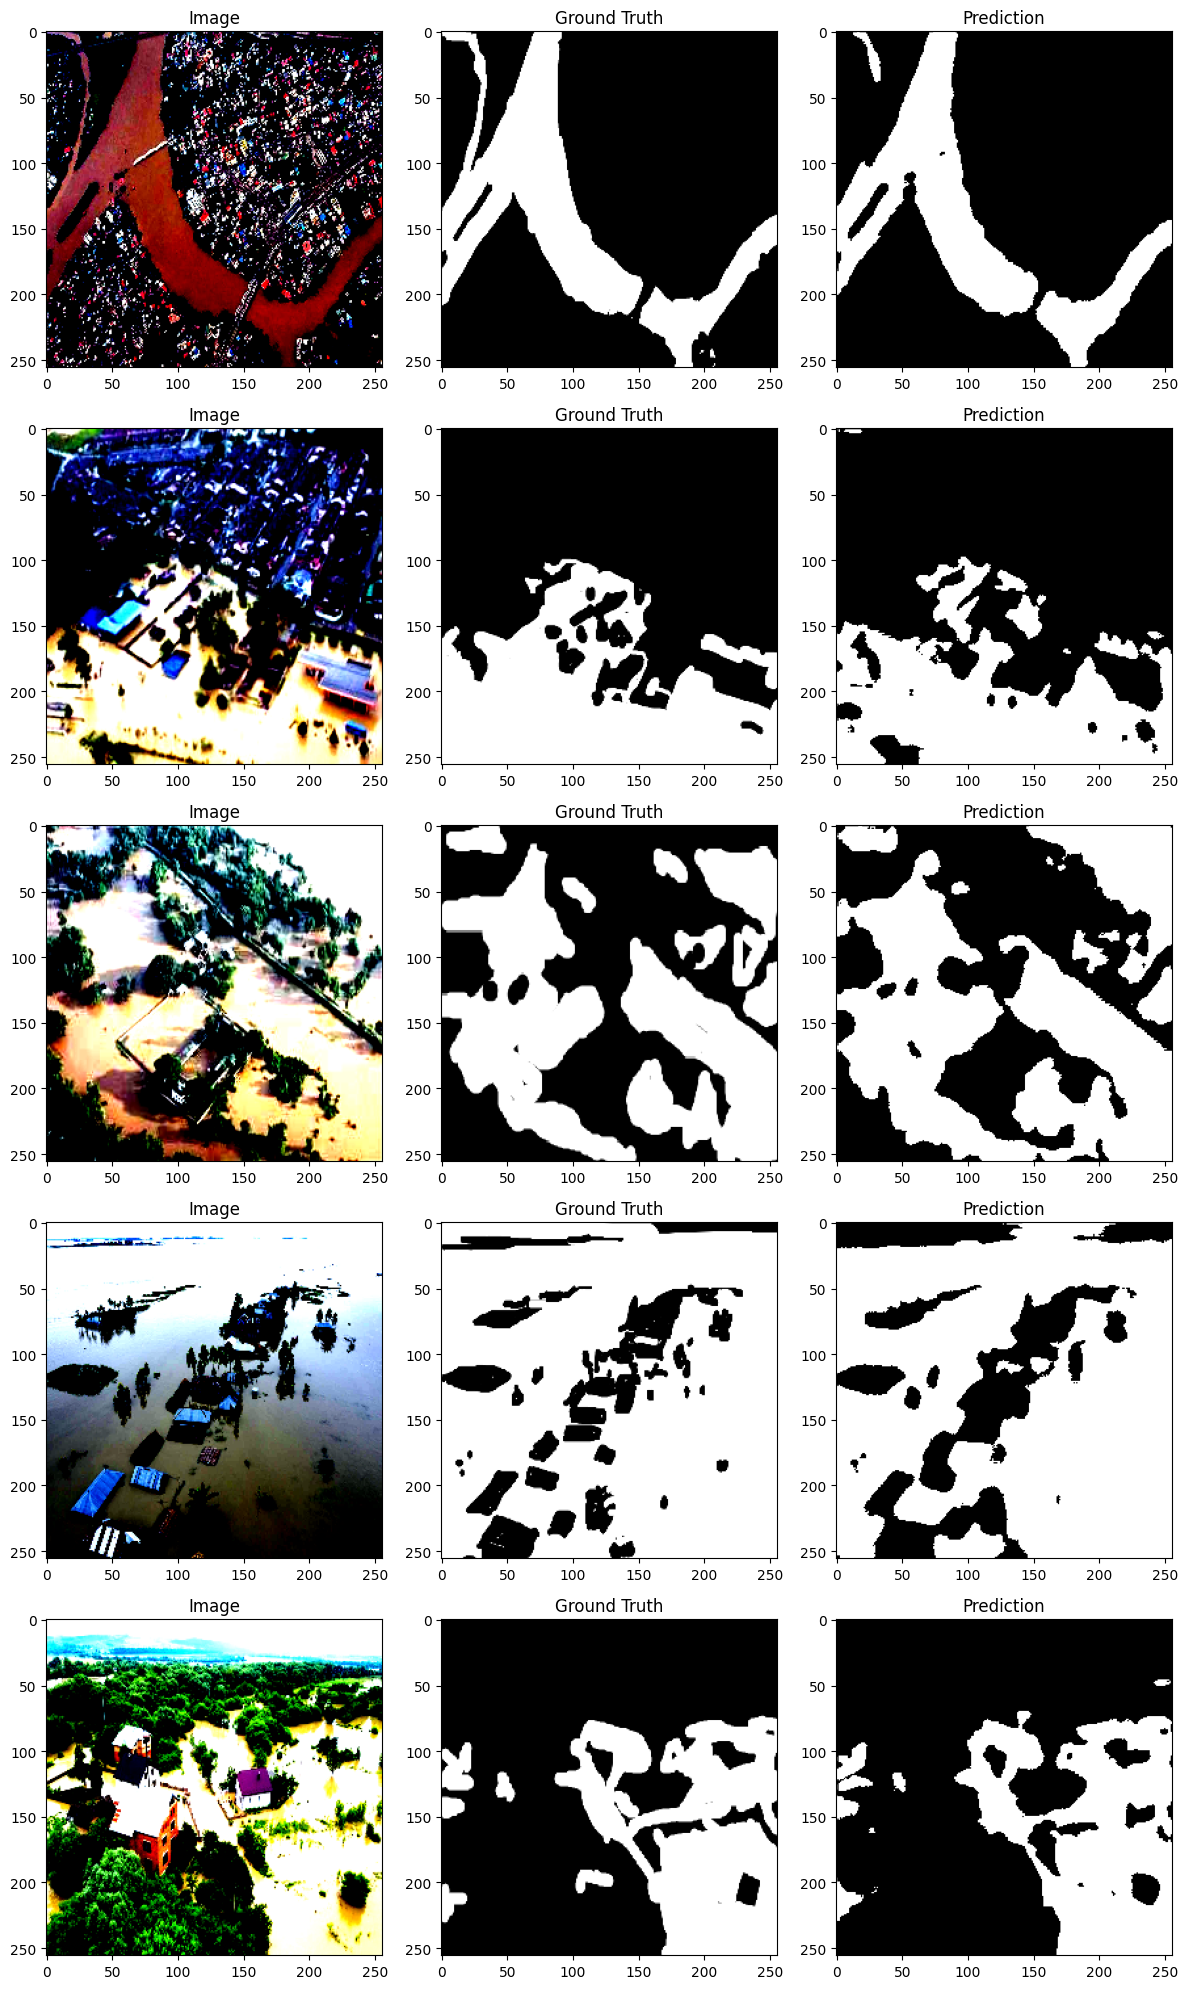

Overlay saved at: overlay_0.png


In [10]:
# Disaster Image Segmentation with U-Net (PyTorch + Albumentations + Enhancements)
# ===============================================================

# 📦 SECTION 1: Imports and Setup
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Ensure reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 🔧 Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 📁 SECTION 2: Data Loading and EDA
IMAGE_DIR = "Dataset/Image"  # Update path
MASK_DIR = "Dataset/Mask"   # Update path

image_paths = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)])
mask_paths = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR)])

print(f"Total Images: {len(image_paths)}, Total Masks: {len(mask_paths)}")

# Sample visualization
def show_sample(img_path, mask_path):
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img)
    axs[0].set_title("Image")
    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Mask")
    plt.show()

show_sample(image_paths[0], mask_paths[0])

# 📊 SECTION 3: Dataset Class with Albumentations
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]).convert("RGB"))
        mask = np.array(Image.open(self.masks[idx]).convert("L"))

        mask = np.array(Image.fromarray(mask).resize(image.shape[:2][::-1], resample=Image.NEAREST))
        mask = mask / 255.0  # Normalize

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)

        return image, mask.float()

# Albumentations Transforms
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=SEED
)

train_dataset = SegmentationDataset(train_imgs, train_masks, transform=train_transform)
val_dataset = SegmentationDataset(val_imgs, val_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# 🧠 SECTION 4: U-Net with Pretrained Backbone
!pip install segmentation-models-pytorch --quiet
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

# 🎯 SECTION 5: Loss, Optimizer, Metrics
def dice_coef(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou_coef(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        BCE = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE
        return F_loss.mean()

loss_fn = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

# 📈 Updated Evaluation Function
def eval_fn(model, dataloader):
    model.eval()
    dice_scores = []
    iou_scores = []
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            dice = dice_coef(outputs, masks)
            iou = iou_coef(outputs, masks)
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())
    return np.mean(dice_scores), np.mean(iou_scores)

def train_fn(model, dataloader, optimizer, loss_fn):
    """Training function for one epoch."""
    model.train()
    total_loss = 0
    
    for batch_idx, (images, masks) in enumerate(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f'  Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
    
    return total_loss / len(dataloader)

# 🔁 SECTION 6: Training Loop with Scheduler and Early Stopping
# 🔁 SECTION 6: Training Loop with Save Path, Scheduler, and Early Stopping
best_dice = 0
patience = 5
counter = 0

MODEL_SAVE_PATH = os.path.join(os.getcwd(), "best_unet_model.pth")
print(f"✅ Model will be saved to: {MODEL_SAVE_PATH}")

for epoch in range(1, 51):  # Up to 50 epochs
    train_loss = train_fn(model, train_loader, optimizer, loss_fn)
    val_dice, val_iou = eval_fn(model, val_loader)
    print(f"Epoch {epoch}, Loss: {train_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}")
    scheduler.step(val_dice)

    if val_dice > best_dice:
        best_dice = val_dice
        counter = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"💾 Best model saved to: {MODEL_SAVE_PATH}")
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


# 📊 SECTION 9: Inference and Visualization
def visualize_prediction(model, dataset, index):
    model.eval()
    image, mask = dataset[index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        pred = model(image_tensor)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Image")
    axs[1].imshow(mask.squeeze().cpu().numpy(), cmap="gray")
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred > 0.5, cmap="gray")
    axs[2].set_title("Prediction")
    plt.show()

# New: Visualize grid of predictions
def visualize_predictions_grid(model, dataset, indices):
    model.eval()
    n = len(indices)
    fig, axs = plt.subplots(n, 3, figsize=(12, 4 * n))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            pred = model(image_tensor)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()

        axs[i, 0].imshow(image.permute(1, 2, 0).cpu().numpy())
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(mask.squeeze().cpu().numpy(), cmap="gray")
        axs[i, 1].set_title("Ground Truth")
        axs[i, 2].imshow(pred > 0.5, cmap="gray")
        axs[i, 2].set_title("Prediction")
    plt.tight_layout()
    plt.show()

# New: Save overlayed prediction image
def save_overlayed_prediction(model, dataset, index, save_path):
    model.eval()
    image, mask = dataset[index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        pred = model(image_tensor)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = image.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)

    pred_mask = (pred > 0.5).astype(np.uint8) * 255
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    pred_colored = cv2.applyColorMap(pred_mask, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_bgr, 0.7, pred_colored, 0.3, 0)
    cv2.imwrite(save_path, overlay)
    print(f"Overlay saved at: {save_path}")

# ✅ Run this block after training to see results
dice, iou = eval_fn(model, val_loader)
print(f"Final Validation Dice: {dice:.4f}, IoU: {iou:.4f}")

visualize_predictions_grid(model, val_dataset, indices=[0, 1, 2, 3, 4])
save_overlayed_prediction(model, val_dataset, index=0, save_path="overlay_0.png")


In [11]:
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [12]:
def eval_fn(model, dataloader):
    model.eval()
    total_dice = 0.0
    total_iou = 0.0
    total_pixels = 0
    correct_pixels = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

            # Accuracy calculation
            correct_pixels += (preds == masks).sum().item()
            total_pixels += torch.numel(preds)

            # Dice & IoU
            intersection = (preds * masks).sum((1, 2, 3))
            union = (preds + masks).sum((1, 2, 3))
            dice = (2 * intersection + 1e-8) / (union + 1e-8)
            iou = (intersection + 1e-8) / (union - intersection + 1e-8)

            total_dice += dice.mean().item()
            total_iou += iou.mean().item()

    overall_acc = correct_pixels / total_pixels
    return total_dice / len(dataloader), total_iou / len(dataloader), overall_acc


In [13]:
dice, iou, accuracy = eval_fn(model, val_loader)
print(f"Validation Dice: {dice:.4f}, IoU: {iou:.4f}, Accuracy: {accuracy:.4f}")


Validation Dice: 0.8369, IoU: 0.7356, Accuracy: 0.8877


In [14]:
# Evaluate best saved model
model.load_state_dict(torch.load("best_unet_model.pth"))
dice, iou, acc = eval_fn(model, val_loader)
print(f"Final Validation Dice: {dice:.4f}, IoU: {iou:.4f}, Accuracy: {acc:.4f}")


C:\Users\Acer\AppData\Local\Temp\ipykernel_22596\2097935565.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_unet_model.pth"))


Final Validation Dice: 0.8382, IoU: 0.7367, Accuracy: 0.8890


In [15]:
import torch
model_data = torch.load("best_unet_model.pth", map_location='cpu')
print("Layer names in your model:")
for i, key in enumerate(list(model_data.keys())[:20]):
    print(f"{i+1}. {key}")

Layer names in your model:
1. encoder.conv1.weight
2. encoder.bn1.weight
3. encoder.bn1.bias
4. encoder.bn1.running_mean
5. encoder.bn1.running_var
6. encoder.bn1.num_batches_tracked
7. encoder.layer1.0.conv1.weight
8. encoder.layer1.0.bn1.weight
9. encoder.layer1.0.bn1.bias
10. encoder.layer1.0.bn1.running_mean
11. encoder.layer1.0.bn1.running_var
12. encoder.layer1.0.bn1.num_batches_tracked
13. encoder.layer1.0.conv2.weight
14. encoder.layer1.0.bn2.weight
15. encoder.layer1.0.bn2.bias
16. encoder.layer1.0.bn2.running_mean
17. encoder.layer1.0.bn2.running_var
18. encoder.layer1.0.bn2.num_batches_tracked
19. encoder.layer1.1.conv1.weight
20. encoder.layer1.1.bn1.weight


C:\Users\Acer\AppData\Local\Temp\ipykernel_22596\1548099064.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load("best_unet_model.pth", map_location='

In [16]:
import torch
import segmentation_models_pytorch as smp

# Test loading
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

checkpoint = torch.load('best_unet_model.pth', map_location='cpu')
model.load_state_dict(checkpoint, strict=False)
print("Model loaded successfully!")

Model loaded successfully!


C:\Users\Acer\AppData\Local\Temp\ipykernel_22596\1095086672.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_unet_model.pth', map_location=

In [17]:
import torch

path = "best_unet_model.pth"
checkpoint = torch.load(path, map_location="cpu")

# Check the type and contents
if isinstance(checkpoint, dict):
    print("Checkpoint keys:", checkpoint.keys())

    if 'model_state_dict' in checkpoint:
        print("✓ Found 'model_state_dict' — it's a checkpoint from training loop.")
    elif 'state_dict' in checkpoint:
        print("✓ Found 'state_dict' — it's a model checkpoint.")
    else:
        print("✓ Might be a raw state_dict directly.")
else:
    print("Loaded object is not a dict. Possibly a full model.")


Checkpoint keys: odict_keys(['encoder.conv1.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.bn1.num_batches_tracked', 'encoder.layer1.0.conv1.weight', 'encoder.layer1.0.bn1.weight', 'encoder.layer1.0.bn1.bias', 'encoder.layer1.0.bn1.running_mean', 'encoder.layer1.0.bn1.running_var', 'encoder.layer1.0.bn1.num_batches_tracked', 'encoder.layer1.0.conv2.weight', 'encoder.layer1.0.bn2.weight', 'encoder.layer1.0.bn2.bias', 'encoder.layer1.0.bn2.running_mean', 'encoder.layer1.0.bn2.running_var', 'encoder.layer1.0.bn2.num_batches_tracked', 'encoder.layer1.1.conv1.weight', 'encoder.layer1.1.bn1.weight', 'encoder.layer1.1.bn1.bias', 'encoder.layer1.1.bn1.running_mean', 'encoder.layer1.1.bn1.running_var', 'encoder.layer1.1.bn1.num_batches_tracked', 'encoder.layer1.1.conv2.weight', 'encoder.layer1.1.bn2.weight', 'encoder.layer1.1.bn2.bias', 'encoder.layer1.1.bn2.running_mean', 'encoder.layer1.1.bn2.running_var', 'encoder.layer1.1.b

C:\Users\Acer\AppData\Local\Temp\ipykernel_22596\2779105908.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location="cpu")
